<a href="https://colab.research.google.com/github/anadiedrichs/datitos-d2l-tp2/blob/main/Diedrichs_Trabajo_pr%C3%A1ctico_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico 2

### Obtener datasets

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adiedrichs","key":"fa0b521922f4b2f947b921ef2db85ae4"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tp-n2-aprendizaje-profundo-2021-by-datitos-v2

  0% 0.00/1.16M [00:00<?, ?B/s]
100% 1.16M/1.16M [00:00<00:00, 80.0MB/s]
  0% 0.00/482k [00:00<?, ?B/s]
100% 482k/482k [00:00<00:00, 64.9MB/s]


In [ ]:
!ls -la

total 20
drwxr-xr-x 1 root root 4096 Apr 16 17:51 .
drwxr-xr-x 1 root root 4096 Apr 16 17:50 ..
drwxr-xr-x 4 root root 4096 Apr  7 13:35 .config
-rw-r--r-- 1 root root   66 Apr 16 17:51 kaggle.json
drwxr-xr-x 1 root root 4096 Apr  7 13:36 sample_data


In [ ]:
!unzip fifa2021_training.csv.zip
!unzip fifa2021_test.csv.zip

Archive:  fifa2021_training.csv.zip
  inflating: fifa2021_training.csv   
Archive:  fifa2021_test.csv.zip
  inflating: fifa2021_test.csv       


### Cargar datasets

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('fifa2021_training.csv')
df_infer = pd.read_csv('fifa2021_test.csv')

### Breve análisis exploratorio

In [ ]:
df.iloc[0]

ID                            243620
Name                   Adam Hellborg
Natinality                    Sweden
Overal                            64
Potential                         73
Height                           188
Weight                            79
PreferredFoot                      R
BirthDate              July 30, 1998
Age                               22
PlayerWorkRate         Medium/Medium
WeakFoot                           3
SkillMoves                         2
Value                        1.2e+06
Wage                            1500
Club                       IK Sirius
Club_KitNumber                     2
Club_JoinedClub         Jan. 8, 2020
Club_ContractLength             2022
BallControl                       62
Dribbling                         55
Marking                           60
SlideTackle                       57
StandTackle                       60
Aggression                        71
Reactions                         58
Interceptions                     60
V

### Particionar datasets

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df, stratify=df.Position, train_size=0.9, random_state=42)

### Definir transformaciones

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

variables_descartar = [
    'Position', # variable objetivo
    'ID',
    'Name',
    'Natinality',
    'BirthDate',
    'Value',
    'Wage',
    'Club',
    'Club_KitNumber',
    'Club_JoinedClub',
    'Club_ContractLength',
]

variables_categóricas = df.drop(columns=variables_descartar).select_dtypes(include=np.object).columns
variables_numéricas   = df.drop(columns=variables_descartar).select_dtypes(include=np.number).columns

transformador = make_column_transformer(
    (OneHotEncoder(),  variables_categóricas), # PreferredFoot, PlayerWorkRate, Sex
    (StandardScaler(), variables_numéricas),   # Overal, Potential, Height, etc.
    remainder='drop' # descarta las columnas no mencionadas en las transformaciones
)

### Entrenar transformador

Esencialmente, calculamos los **promedios** y las **desviaciones estándares** que usaremos para la estandarización.

**ESTOS VALORES SOLO DEBEN SER OBTENIDOS DEL DATASET DE ENTRENAMIENTO**.

In [ ]:
transformador.fit(df_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('onehotencoder',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=True),
                                 Index(['PreferredFoot', 'PlayerWorkRate', 'Sex'], dtype='object')),
                                ('standardscaler',
                                 StandardScaler(copy=True, with_mean=Tr...
       'StandTackle', 'Aggression', 'Reactions', 'Interceptions', 'Vision',
       'Composure', 'Crossing', 'ShortPass', 'LongPass', 'Acceleration',
       'Stamina', 'Strength', 'Balance', 'SprintSpeed', 'Agility', 'Jumping',
       'Heading', 'ShotPower', 'Finishing', 'LongShots', 'Curve', 'FKAcc',
       'Penalties',

### Transformar datasets

In [ ]:
# el transformador se queja si falta alguna columna de df_train :/
df_infer['Position'] = None


X_train = transformador.transform(df_train)
X_valid = transformador.transform(df_valid)
X_infer = transformador.transform(df_infer)

In [ ]:
X_infer.shape

(5909, 52)

### Transformar variable objetivo

Como la variable objetivo es del tipo string, hay que llevarla a un tipo numérico para que PyTorch pueda procesarla.

Este transformador mapea posiciones DEF, FWD, GK, MID a enteros **y viceversa** — la transformación inversa será útil para convertir las predicciones (enteros) en posiciones otra vez.

In [ ]:
from sklearn.preprocessing import LabelEncoder

transformador_etiquetas = LabelEncoder()

transformador_etiquetas.fit(df_train.Position)

y_train = transformador_etiquetas.transform(df_train.Position)
y_valid = transformador_etiquetas.transform(df_valid.Position)

### Instanciar Datasets de PyTorch

El aprendizaje profundo es especialmente efectivo para imágenes y texto; para datos tabulares (como un DataFrame) el aprendizaje de máquinas clásico suele funcionar bastante bien, de ahí que PyTorch no cuente con facilidades para tratar este tipo de problemas.

In [ ]:
from torch.utils.data import Dataset

class Tabular(Dataset):
    def __init__(self, X, y=None):
        self.X = X.astype(np.float32) # soluciona "Expected object of scalar type Float but got scalar type Double"
        self.y = y 

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, item):
        if self.y is None:
            return self.X[item]
        else:
            return self.X[item], self.y[item]

        
ds_train = Tabular(X_train, y_train)

Como el dataset es liviano y entra en la memoria, para validación e inferencia en vez de hacer esto

```python
ds_valid = Tabular(X_valid, y_valid)
ds_infer = Tabular(X_infer)
```

vamos a usar tensores simplemente para no complicarla.

In [ ]:
ds_train[10]

(array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  2.2005258 ,  1.7577571 ,
         1.6827489 ,  0.69650096,  1.9552506 ,  2.9999895 , -0.49693993,
         1.5163243 ,  1.0263261 ,  0.5255314 , -1.4219726 , -0.93868953,
         0.10657337,  2.1206129 ,  0.13522774,  1.5071335 ,  2.1563685 ,
         0.6801946 ,  1.1708272 ,  1.3763508 , -0.25280562,  0.7491539 ,
         1.286718  , -2.0082333 , -0.4727765 , -0.531109  , -0.06149001,
         1.7349557 ,  2.030825  ,  2.0725315 ,  1.5956575 ,  0.90770805,
         0.6198386 ,  1.1499894 ,  1.857724  , -0.42461264, -0.31164196,
        -0.19319764, -0.09562566], dtype=float32), 1)

### Instanciar DataLoaders de PyTorch

In [ ]:
from torch.utils.data import DataLoader

dl_train = DataLoader(ds_train, batch_size=32, shuffle=True)

Una de las cosas que `DataLoader` hace es convertir arreglos de NumPy en tensores de PyTorch.

Como no vamos a hacer esto

```python
# sin shuffle porque validación e inferencia no requieren barajar sus elementos 
dl_valid = DataLoader(ds_valid, batch_size=32)
dl_infer = DataLoader(ds_infer, batch_size=32)
```

vamos a definir tensores a mano.

In [ ]:
import torch

X_valid = torch.tensor(X_valid).float()
X_infer = torch.tensor(X_infer).float()

y_valid = torch.tensor(y_valid)

### Instanciar modelo

In [ ]:
import torch
import torch.nn as nn

In [ ]:
IN  = X_train.shape[1]
OUT = len(transformador_etiquetas.classes_)

modelo = nn.Sequential(
    nn.Linear(IN,  8),
    nn.Linear( 8, 64), nn.Tanh(), #nn.ReLU(),
    nn.Linear(64, 32), nn.Tanh(), # nn.ReLU()
    nn.Linear(32, OUT)
)

In [ ]:
criterio = nn.CrossEntropyLoss()
optimizador = torch.optim.Adam(modelo.parameters(), lr=0.001) # Adam # SGD 

### Reproducibilidad

In [ ]:
torch.manual_seed(3)
import random
random.seed(3)

### Entrenar modelo

In [ ]:
from sklearn.metrics import balanced_accuracy_score

ÉPOCAS = 30

train_loss = []
valid_loss = []
accuracy = []

for época in range(ÉPOCAS):
    # activa capas Dropout, BatchNorm si las hubiese
    modelo.train()

    pérdidas_train = []
    for X_lote, y_lote in dl_train:
        optimizador.zero_grad()

        predicciones = modelo(X_lote)
        pérdida = criterio(predicciones, y_lote)

        pérdida.backward()
        optimizador.step()
        
        pérdidas_train.append(pérdida.item())
    
    # desactiva capas Dropout, BatchNorm si las hubiese
    modelo.eval()
    
    with torch.no_grad():
        predicciones = modelo(X_valid)
        pérdida = criterio(predicciones, y_valid)
        
        y_pred = predicciones.argmax(dim=1) # selecciona la clase con mayor probabilidad
        
        efectividad = balanced_accuracy_score(y_valid, y_pred)

    train_loss.append(np.mean(pérdidas_train))
    valid_loss.append(pérdida)
    accuracy.append(efectividad)

    print(f'{época:3d}  |  Train loss: {np.mean(pérdidas_train):.3f}    Valid loss: {pérdida:.3f}    Valid accuracy: {efectividad:.2f}')

  0  |  Train loss: 0.414    Valid loss: 0.292    Valid accuracy: 0.89
  1  |  Train loss: 0.268    Valid loss: 0.269    Valid accuracy: 0.89
  2  |  Train loss: 0.257    Valid loss: 0.265    Valid accuracy: 0.89
  3  |  Train loss: 0.249    Valid loss: 0.260    Valid accuracy: 0.89
  4  |  Train loss: 0.246    Valid loss: 0.260    Valid accuracy: 0.88
  5  |  Train loss: 0.241    Valid loss: 0.257    Valid accuracy: 0.90
  6  |  Train loss: 0.238    Valid loss: 0.261    Valid accuracy: 0.88
  7  |  Train loss: 0.237    Valid loss: 0.257    Valid accuracy: 0.89
  8  |  Train loss: 0.233    Valid loss: 0.260    Valid accuracy: 0.89
  9  |  Train loss: 0.231    Valid loss: 0.258    Valid accuracy: 0.90
 10  |  Train loss: 0.230    Valid loss: 0.261    Valid accuracy: 0.89
 11  |  Train loss: 0.228    Valid loss: 0.256    Valid accuracy: 0.89
 12  |  Train loss: 0.227    Valid loss: 0.266    Valid accuracy: 0.89
 13  |  Train loss: 0.227    Valid loss: 0.258    Valid accuracy: 0.89
 14  |

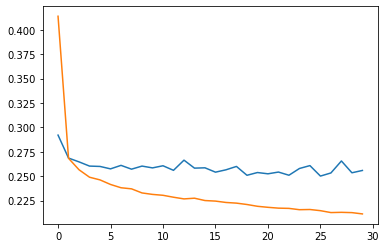

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(0,ÉPOCAS),valid_loss,
         range(0,ÉPOCAS),train_loss)

### Inferir datos de prueba

In [ ]:
with torch.no_grad():
    y_infer = modelo(X_infer).argmax(dim=1)

df_infer['Position'] = transformador_etiquetas.inverse_transform(y_infer)

(
    df_infer[['ID', 'Position']]
    .rename(columns={'ID':'Id', 'Position':'Category'})
    .to_csv('submit.csv', index=False)
)

### Subir predicciones

In [ ]:
!kaggle competitions submit -c tp-n2-aprendizaje-profundo-2021-by-datitos-v2 -f submit.csv -m "un dos tres probando"

100% 62.8k/62.8k [00:01<00:00, 34.4kB/s]
Successfully submitted to T.P. N�2 - Aprendizaje Profundo 2021 by Datitos

La 5ta submissión resultó en un score de 0.91155, por el momento, liderando el puntaje, aunque no sea garantía de ganar la competencia.

### Selección de modelos

Luego de bastante prueba y error el modelo que pareció rankear bien fue el siguiente:

* Learning rate de 0.001. Valores más grandes hacían oscilar los valores de loss. Valores más pequeños demoraban la convergencia de las curvas loss.
* Función de activación de las capas intermedias: tangente hiperbólica
* batch size 32 (venía por defecto)
* 

### Caso de cross entropy loss ponderado

definir arquitectura de la red y weighted cross entropy loss

In [ ]:
import torch
import torch.nn as nn

torch.manual_seed(3)
import random
random.seed(3)

IN  = X_train.shape[1]
OUT = len(transformador_etiquetas.classes_)

modelo = nn.Sequential(
    nn.Linear(IN,  8),
    nn.Linear( 8, 64), nn.Tanh(), #nn.ReLU(),
    nn.Linear(64, 32), nn.Tanh(), # nn.ReLU()
    nn.Linear(32, OUT)
)
sc=torch.tensor([0.5,0.5,1,0.5]) # ¿cuál es la posición de cada clase? 
criterio = nn.CrossEntropyLoss(weight=sc)
optimizador = torch.optim.Adam(modelo.parameters(), lr=0.001) # Adam # SGD

In [ ]:
from sklearn.metrics import balanced_accuracy_score

ÉPOCAS = 30

train_loss = []
valid_loss = []
accuracy = []

for época in range(ÉPOCAS):
    # activa capas Dropout, BatchNorm si las hubiese
    modelo.train()

    pérdidas_train = []
    for X_lote, y_lote in dl_train:
        optimizador.zero_grad()

        predicciones = modelo(X_lote)
        pérdida = criterio(predicciones, y_lote)

        pérdida.backward()
        optimizador.step()
        
        pérdidas_train.append(pérdida.item())
    
    # desactiva capas Dropout, BatchNorm si las hubiese
    modelo.eval()
    
    with torch.no_grad():
        predicciones = modelo(X_valid)
        pérdida = criterio(predicciones, y_valid)
        
        y_pred = predicciones.argmax(dim=1) # selecciona la clase con mayor probabilidad
        
        efectividad = balanced_accuracy_score(y_valid, y_pred)

    train_loss.append(np.mean(pérdidas_train))
    valid_loss.append(pérdida)
    accuracy.append(efectividad)

    print(f'{época:3d}  |  Train loss: {np.mean(pérdidas_train):.3f}    Valid loss: {pérdida:.3f}    Valid accuracy: {efectividad:.2f}')
    

  0  |  Train loss: 0.400    Valid loss: 0.266    Valid accuracy: 0.89
  1  |  Train loss: 0.247    Valid loss: 0.253    Valid accuracy: 0.89
  2  |  Train loss: 0.232    Valid loss: 0.243    Valid accuracy: 0.89
  3  |  Train loss: 0.226    Valid loss: 0.233    Valid accuracy: 0.89
  4  |  Train loss: 0.221    Valid loss: 0.239    Valid accuracy: 0.89
  5  |  Train loss: 0.218    Valid loss: 0.228    Valid accuracy: 0.89
  6  |  Train loss: 0.215    Valid loss: 0.227    Valid accuracy: 0.89
  7  |  Train loss: 0.212    Valid loss: 0.227    Valid accuracy: 0.89
  8  |  Train loss: 0.210    Valid loss: 0.234    Valid accuracy: 0.89
  9  |  Train loss: 0.210    Valid loss: 0.229    Valid accuracy: 0.89
 10  |  Train loss: 0.207    Valid loss: 0.228    Valid accuracy: 0.89
 11  |  Train loss: 0.207    Valid loss: 0.227    Valid accuracy: 0.89
 12  |  Train loss: 0.205    Valid loss: 0.235    Valid accuracy: 0.89
 13  |  Train loss: 0.205    Valid loss: 0.225    Valid accuracy: 0.89
 14  |

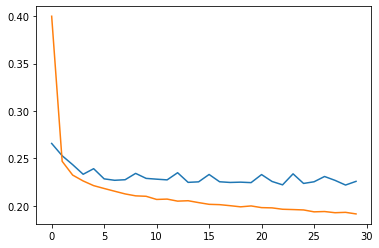

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(0,ÉPOCAS),valid_loss,
         range(0,ÉPOCAS),train_loss)

In [ ]:
with torch.no_grad():
    y_infer = modelo(X_infer).argmax(dim=1)

df_infer['Position'] = transformador_etiquetas.inverse_transform(y_infer)

(
    df_infer[['ID', 'Position']]
    .rename(columns={'ID':'Id', 'Position':'Category'})
    .to_csv('submit.csv', index=False)
)

In [ ]:
!kaggle competitions submit -c tp-n2-aprendizaje-profundo-2021-by-datitos-v2 -f submit.csv -m "un dos tres probando"

100% 62.8k/62.8k [00:02<00:00, 28.4kB/s]
403 - Your team has used its submission allowance (2 of 2). This resets at midnight UTC (5.6 hours from now).


Submission score scored 0.89348 lo cual no es la mejor puntuación comparada a la anterior